In [21]:
import chess.pgn
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import json

pgn_path = "data/all_lichess_elite_games.pgn"

In [ ]:
def count_games(pgn_path):
    count = 0
    with open(pgn_path, 'r', encoding='utf-8') as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            count += 1
            if count % 1000000 == 0:
                print(f"{count} games counted...")
    return count

total_games = count_games(pgn_path)
print(f"Total games: {total_games}")

### Data understanding

In this notebook, I will analyze the dataset from lichess. This dataset is an elite dataset were only games from high rated titled players are included. This dataset does not include bullet (1 or 2 minute games), but only classical, rapid and blitz games. There is a total of around 3.8 million games in the set. The dataset is in PGN format, which is a standard format for chess games. Each game is stored in a single line with the moves and metadata. This differs from FEN were only a single position is stored. The actual game is stored as standard algebraic notation (SAN) move list. This dataset only has the game itself plus some information about the game. Termination is also included, which stores how the game has ended. Normal is just by regular rules of chess (checkmate, stalemate, resignation and a couple more) and when it's not normal it's either on time or something weird happened like rule violations, abandonment of the game or the PGN is broken. ECO codes are included which show the opening played in the game, in the other opening tab it shows the variation inside the opening as well.

[Event "Rated Blitz game"]
[Date "????.??.??"]
[Round "?"]
[White "skopje123"]
[Black "NIGHTGUEST"]
[Result "0-1"]
[WhiteElo "2361"]
[BlackElo "2429"]
[ECO "D02"]
[Opening "Queen's Gambit Refused: Baltic Defense"]
[TimeControl "180+0"]
[UTCDate "2015.08.31"]
[UTCTime "22:00:17"]
[Termination "Normal"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+9"]

1. d4 d5 2. c4 Bf5 3. cxd5 Bxb1 4. Rxb1 Qxd5 5. e3 Nc6 6. Ne2 e5 7. Nc3 Bb4 8. Bd2 Bxc3 9. bxc3 exd4 10. cxd4 Nf6 11. Rb5 Qxa2 12. Rxb7 O-O 13. Be2 Ne4 14. Bf3 Nxd2 15. Bxc6 Qa6 16. Qxd2 Qxc6 17. Rb1 Qxg2 18. Ke2 Qg4+ 19. Kf1
Rfb8 20. Rc1 a5 21. Rg1 Qh3+ 22. Rg2 a4 23. Rxc7 a3 24. Rc2 Rb1+ 25. Rc1 a2 26. Ke2 Rxc1 0-1

### Data analysis / cleaning

I'm starting with 10000 games for testing, but I will increase this number later. I will only consider games that are longer than 14 half-moves(7 for each side) and shorter than 200 half-moves(100 for each side) as the longer games are probably in time constraint and the shorter games are probably were aborted or not finished in the dataset. As for the timecontrol I will keep it like this for now but might change it to only rapid or longer time controls as there are a lot of mistakes made in 3+0 games.

In [20]:
feature_data = [
    ("Event", "Rated Blitz game", "Type of game or tournament."),
    ("Date", "????.??.??", "Date of the event (may be missing)."),
    ("Round", "?", "Round number (often unknown in online games)."),
    ("White", "skopje123", "Username of the White player."),
    ("Black", "NIGHTGUEST", "Username of the Black player."),
    ("Result", "0-1", "Game outcome: 1-0 (White wins), 0-1 (Black wins), 1/2-1/2 (Draw)."),
    ("WhiteElo", "2361", "White player's rating before the game."),
    ("BlackElo", "2429", "Black player's rating before the game."),
    ("ECO", "D02", "ECO opening code (standardized)."),
    ("Opening", "Queen's Gambit Refused: Baltic Defense", "Full name of the opening variation."),
    ("TimeControl", "180+0", "Base time (s) + increment (s)."),
    ("UTCDate", "2015.08.31", "Date the game started (UTC)."),
    ("UTCTime", "22:00:17", "Time the game started (UTC)."),
    ("Termination", "Normal", "How the game ended (Normal, Time forfeit, etc.)."),
    ("WhiteRatingDiff", "-9", "Rating change for White."),
    ("BlackRatingDiff", "+9", "Rating change for Black."),
    ("Moves", "1. d4 d5 2. c4 ...", "List of moves from the PGN body in Standard Algebraic Notation (SAN).")
]

feature_df = pd.DataFrame(feature_data, columns=["Feature", "Example", "Description"])

display(feature_df)

,Feature,Example,Description
0,Event,Rated Blitz game,Type of game or tournament.
1,Date,????.??.??,Date of the event (may be missing).
2,Round,?,Round number (often unknown in online games).
3,White,skopje123,Username of the White player.
4,Black,NIGHTGUEST,Username of the Black player.
5,Result,0-1,"Game outcome: 1-0 (White wins), 0-1 (Black win..."
6,WhiteElo,2361,White player's rating before the game.
7,BlackElo,2429,Black player's rating before the game.
8,ECO,D02,ECO opening code (standardized).
9,Opening,Queen's Gambit Refused: Baltic Defense,Full name of the opening variation.


Game Result Distribution:


,Result,Count
0,1-0,4701
1,0-1,4408
2,1/2-1/2,825


Most Common First Moves:


,First Move,Frequency
0,e4,4711
1,d4,3448
2,Nf3,794
3,c4,517
4,b3,123
5,g3,93
6,b4,64
7,Nc3,46
8,f4,39
9,e3,37


Time Control Frequencies:


,Time Control,Count,Category
0,180+0,8647,Blitz
7,180+1,360,Blitz
5,180+2,209,Blitz
2,300+0,175,Blitz
6,60+3,132,Bullet
18,120+2,116,Bullet
9,240+0,93,Blitz
3,180+3,42,Blitz
15,480+0,34,Blitz
24,600+0,12,Rapid


Time Control Categories:


,Category,Count
0,Blitz,9633
1,Bullet,269
3,Rapid,31
2,Classical,1


Average Game Length (plies): 82.32
Most Common Full Openings:


,Opening,Count
0,Scandinavian Defense: Main Line,236
1,Scandinavian Defense: Mieses-Kotroc Variation,218
2,Trompowsky Attack,180
3,Sicilian Defense: Alapin Variation,144
4,Scandinavian Defense,142
5,"Trompowsky Attack: Classical Defense, Big Cent...",106
6,"Scandinavian Defense: Main Line, Mieses Variation",97
7,Scandinavian Defense: Gubinsky-Melts Defense,96
8,"Sicilian Defense: Alapin Variation, Barmen Def...",95
9,Modern Defense,91


Most Common ECO Codes:


,ECO Code,Count
0,B01,961
1,A45,471
2,B22,273
3,A40,263
4,A00,241
5,D02,235
6,B06,223
7,A04,220
8,B12,186
9,A46,182


Game Termination Types:


,Termination,Count
0,Normal,7596
1,Time forfeit,2338


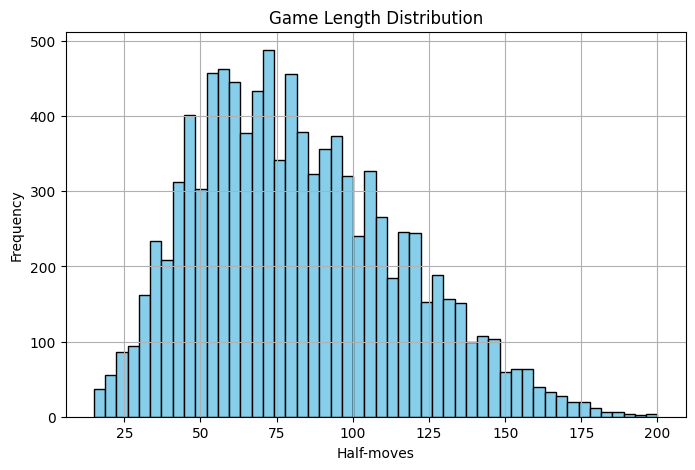

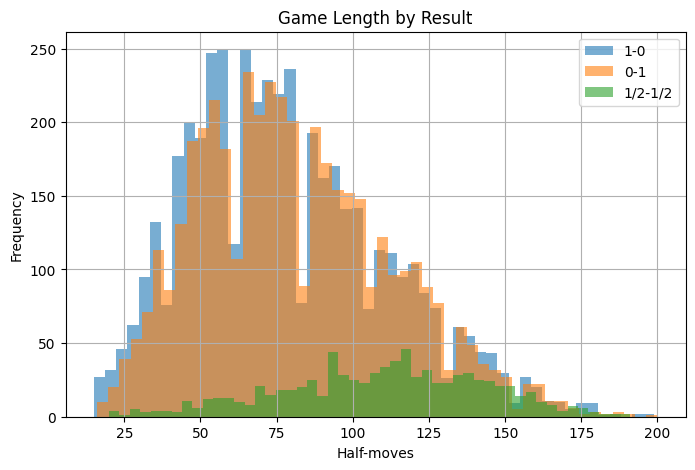

In [17]:
def analyze_pgn_file(path, max_games=10000, min_halfmoves=15, max_halfmoves=200):
    result_counter = Counter()
    first_move_counter = Counter()
    game_lengths = []
    time_controls = Counter()
    opening_counter = Counter()
    eco_counter = Counter()
    termination_counter = Counter()
    lengths_by_result = {"1-0": [], "0-1": [], "1/2-1/2": []}

    with open(path, encoding='utf-8') as f:
        for i in range(max_games):
            game = chess.pgn.read_game(f)
            if game is None:
                break

            moves = list(game.mainline_moves())
            plies = len(moves)

            if plies < min_halfmoves or plies > max_halfmoves:
                continue

            opening_name = game.headers.get("Opening", "Unknown")
            opening_counter[opening_name] += 1

            eco = game.headers.get("ECO", "Unknown")
            eco_counter[eco] += 1

            termination = game.headers.get("Termination", "Unknown")
            termination_counter[termination] += 1

            result = game.headers.get("Result", "unknown")
            result_counter[result] += 1

            if result in lengths_by_result:
                lengths_by_result[result].append(plies)

            tc = game.headers.get("TimeControl", "?")
            time_controls[tc] += 1

            game_lengths.append(plies)

            board = game.board()
            if moves:
                first_move = board.san(moves[0])
                first_move_counter[first_move] += 1

    return result_counter, first_move_counter, game_lengths, time_controls, opening_counter, eco_counter, termination_counter, lengths_by_result

def categorize_time_control(tc_str):
    if "+" not in tc_str or tc_str == "?":
        return "Unknown"
    try:
        base, inc = tc_str.split("+")
        base = int(base)
        if base < 180:
            return "Bullet"
        elif base < 600:
            return "Blitz"
        elif base < 1800:
            return "Rapid"
        else:
            return "Classical"
    except:
        return "Unknown"

results, first_moves, lengths, time_controls, openings, ecos, terminations, lengths_by_result = analyze_pgn_file(pgn_path)

results_df = pd.DataFrame(results.items(), columns=["Result", "Count"]).sort_values(by="Count", ascending=False)
first_moves_df = pd.DataFrame(first_moves.most_common(10), columns=["First Move", "Frequency"])
tc_df = pd.DataFrame(time_controls.items(), columns=["Time Control", "Count"]).sort_values(by="Count", ascending=False)

tc_df["Category"] = tc_df["Time Control"].apply(categorize_time_control)
tc_category_df = tc_df.groupby("Category")["Count"].sum().reset_index().sort_values(by="Count", ascending=False)

print("Game Result Distribution:")
display(results_df)

print("Most Common First Moves:")
display(first_moves_df)

print("Time Control Frequencies:")
display(tc_df)

print("Time Control Categories:")
display(tc_category_df)

avg_length = sum(lengths) / len(lengths)
print(f"Average Game Length (plies): {avg_length:.2f}")

openings_df = pd.DataFrame(openings.most_common(10), columns=["Opening", "Count"])
print("Most Common Full Openings:")
display(openings_df)

eco_df = pd.DataFrame(ecos.most_common(10), columns=["ECO Code", "Count"])
print("Most Common ECO Codes:")
display(eco_df)

termination_df = pd.DataFrame(terminations.items(), columns=["Termination", "Count"]).sort_values(by="Count", ascending=False)
print("Game Termination Types:")
display(termination_df)

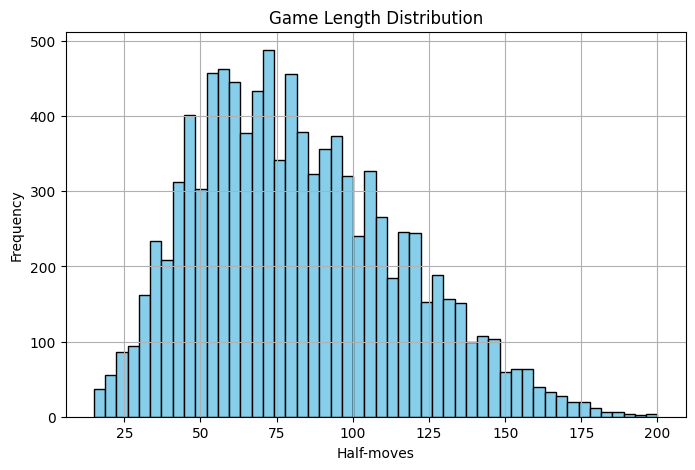

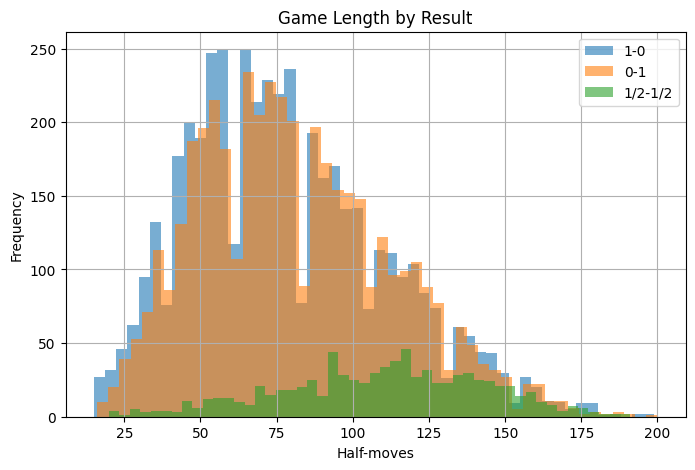

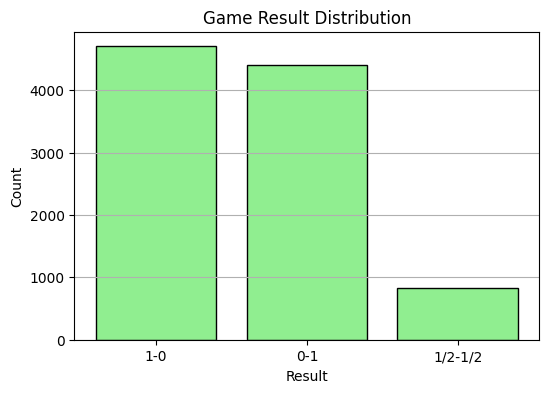

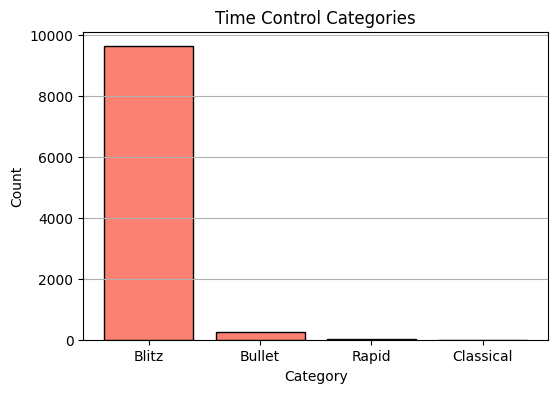

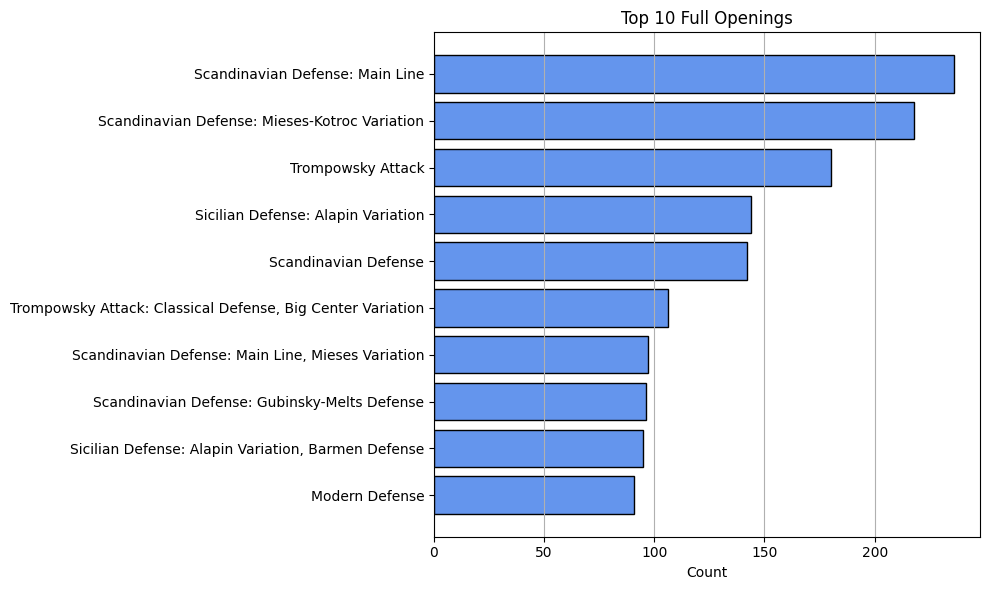

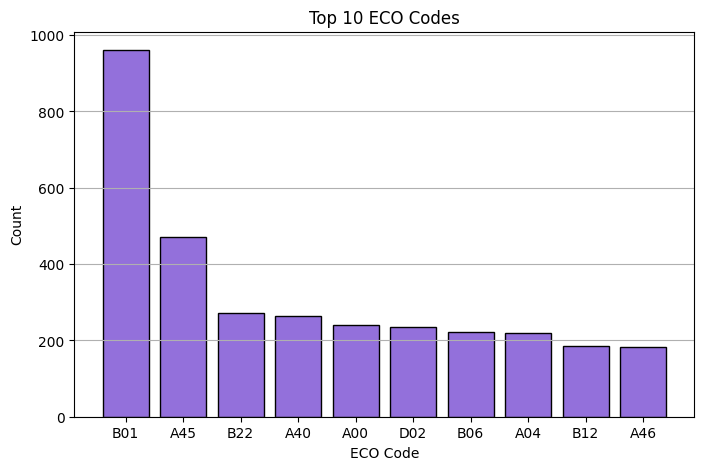

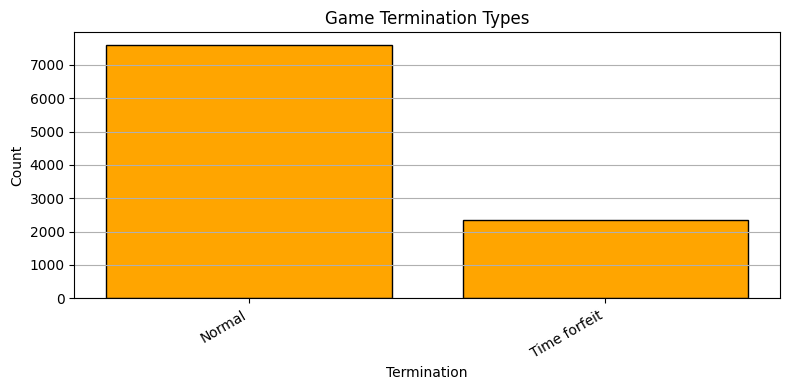

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Game Length Distribution")
plt.xlabel("Half-moves")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
for result, length_list in lengths_by_result.items():
    if length_list:
        plt.hist(length_list, bins=50, alpha=0.6, label=result)
plt.title("Game Length by Result")
plt.xlabel("Half-moves")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(results_df["Result"], results_df["Count"], color="lightgreen", edgecolor="black")
plt.title("Game Result Distribution")
plt.xlabel("Result")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(tc_category_df["Category"], tc_category_df["Count"], color="salmon", edgecolor="black")
plt.title("Time Control Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(openings_df["Opening"][::-1], openings_df["Count"][::-1], color="cornflowerblue", edgecolor="black")
plt.title("Top 10 Full Openings")
plt.xlabel("Count")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(eco_df["ECO Code"], eco_df["Count"], color="mediumpurple", edgecolor="black")
plt.title("Top 10 ECO Codes")
plt.xlabel("ECO Code")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(termination_df["Termination"], termination_df["Count"], color="orange", edgecolor="black")
plt.title("Game Termination Types")
plt.xlabel("Termination")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Modeling

To actually be able to use this data for modeling I will need to convert the data to a format that is usable for machine learning. I came to the conclusion that I would need to make groups of moves and the last move will be the target variable. So lets say this is a group: E4, E5, Nf3, Nc6. The target variable would be Nc6 and the input variables would be E4, E5, Nf3. Maybe adding the opening as a feature could be useful as well, but I will start without.
For the input I will be using a fixed length of 5 moves to start off, but I will be tuning this later.

In [22]:
def extract_move_sequence_dataset(pgn_path, json_output_path, max_games=10000, min_halfmoves=15, max_halfmoves=200, fixed_input_len=5):
    dataset = []
    with open(pgn_path, encoding='utf-8') as f:
        for game_idx in range(max_games):
            game = chess.pgn.read_game(f)
            if game is None:
                break

            # Get moves and filter by game length
            board = game.board()
            moves = []
            for move in game.mainline_moves():
                moves.append(board.san(move))
                board.push(move)

            if len(moves) < min_halfmoves or len(moves) > max_halfmoves:
                continue

            # Create input and target variable groups
            for i in range(fixed_input_len, len(moves)):
                input_sequence = moves[i - fixed_input_len:i]
                target_move = moves[i]
                
                dataset.append({
                    "input": input_sequence,
                    "target": target_move
                })

    with open(json_output_path, "w", encoding="utf-8") as out_file:
        json.dump(dataset, out_file, ensure_ascii=False, indent=2)

    print(f"Done. Saved {len(dataset)} samples to {json_output_path}")

json_output_path = "Data/lichess_move_dataset.json"
extract_move_sequence_dataset(pgn_path, json_output_path, max_games=10000)

\Done. Saved 768117 samples to Data/lichess_move_dataset.json


Because models need numbers to train on, I will need to convert the moves to numbers. I will use a dictionary that will map each move to a unique int. This allows me to convert the moves to numbers and back again. So the input will be numbers and the target variables as well, but the output will be the move in SAN notation.

In [23]:
import json
from collections import Counter

def build_vocab(json_path):
    with open(json_path, encoding="utf-8") as f:
        data = json.load(f)

    move_counter = Counter()
    for sample in data:
        move_counter.update(sample["input"])
        move_counter.update([sample["target"]])

    moves = sorted(move_counter.keys())

    vocab = {move: idx for idx, move in enumerate(moves)}

    return vocab

json_path = "Data/lichess_move_dataset.json"
vocab = build_vocab(json_path)

print(f"Vocabulary built with {len(vocab)} unique moves.")
print("Sample (first 10):")

for move, idx in list(vocab.items())[:10]:
    print(f"{move}: {idx}")

Vocabulary built with 3732 unique moves.
Sample (first 10):
Ba1: 0
Ba2: 1
Ba2+: 2
Ba3: 3
Ba3+: 4
Ba4: 5
Ba4#: 6
Ba4+: 7
Ba5: 8
Ba5+: 9


This is a classification problem, where I need to classify the next move based on a sequence of previous moves. For this I think a Long Short-Term Memory(LSTM) model looks like a good initial choice, LSTMs are designed to handle sequential data and can capture patters over time, hopefully like opening structures or tactical motifs.